In [118]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import pearsonr, mannwhitneyu, f_oneway

In [119]:
df = sns.load_dataset('taxis')
df

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,credit card,East Harlem North,Central Harlem North,Manhattan,Manhattan
6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,credit card,Jamaica,East Concourse/Concourse Village,Queens,Bronx
6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,cash,Crown Heights North,Bushwick North,Brooklyn,Brooklyn
6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,credit card,East New York,East Flatbush/Remsen Village,Brooklyn,Brooklyn


In [120]:
def describe_df(data:pd.DataFrame) -> pd.DataFrame:
    '''
    Genera una descripción esquemática de las variables de un DataFrame, devolviendo un nuevo DataFrame en el que cada columna corresponde a una variable
    del conjunto de datos original y cada fila resume una propiedad de dicha variable.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame de entrada del que se desea obtener un resumen descriptivo de sus variables.

    Returns
    -------
    pandas.DataFrame
        DataFrame resumen que contiene, para cada variable del DataFrame original, información relativa al tipo de dato, porcentaje de valores nulos,
        número de valores únicos y porcentaje de cardinalidad.
    '''


    salida = {columna: [] for columna in data.columns}
    for columna in salida.keys():
        salida[columna].append(data[columna].dtype)
        salida[columna].append(round(data[columna].isna().sum() / len(data) * 100, 1))
        salida[columna].append(data[columna].nunique())
        salida[columna].append(round(data[columna].nunique() / len(data) * 100, 2))

    salida['Columnas'] = ['DATA_TYPE', 'MISSINGS (%)', 'UNIQUE_VALUES', 'CARDIN (%)']

    return pd.DataFrame(salida).set_index('Columnas')

In [121]:
describe_df(df)

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
Columnas,,,,,,,,,,,,,,
DATA_TYPE,datetime64[ns],datetime64[ns],int64,float64,float64,float64,float64,float64,object,object,object,object,object,object
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.4,0.7,0.4,0.7
UNIQUE_VALUES,6414,6425,7,1079,220,489,16,898,2,2,194,203,4,5
CARDIN (%),99.7,99.88,0.11,16.77,3.42,7.6,0.25,13.96,0.03,0.03,3.02,3.16,0.06,0.08


In [122]:
def tipifica_variables(data:pd.DataFrame, umbral_categoria:int, umbral_continua:float) -> pd.DataFrame:
    '''
    Asigna un tipo sugerido a cada variable de un DataFrame según su cardinalidad, indicando si debe considerarse categórica o numérica (continua o
    discreta).

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame de entrada con las variables a analizar.
    umbral_categoria : int
        Umbral de cardinalidad para diferenciar variables categóricas de numéricas.
    umbral_continua : float
        Porcentaje de cardinalidad mínimo para considerar una variable numérica como continua.

    Returns
    -------
    pandas.DataFrame
        DataFrame con dos columnas: 'nombre_variable' y 'tipo_sugerido', con una fila por cada variable del DataFrame original.
    '''



    describe = describe_df(data)

    salida = [[columna] for columna in data.columns]
    for columna in salida:
        tipo_sugerido = 'Numérica Discreta'
        if describe.loc['UNIQUE_VALUES', columna].values[0] == 2:
            tipo_sugerido = 'Binaria'

        elif describe.loc['CARDIN (%)', columna].values[0] < umbral_categoria:
            tipo_sugerido = 'Categórica'

        elif describe.loc['CARDIN (%)', columna].values[0] >= umbral_continua:
            tipo_sugerido = 'Numérica Continua'

        columna.append(tipo_sugerido)

    return pd.DataFrame(salida, columns=['nombre_variable', 'tipo_sugerido'])

In [123]:
tipifica_variables(df, 1, 10)

,nombre_variable,tipo_sugerido
0,pickup,Numérica Continua
1,dropoff,Numérica Continua
2,passengers,Categórica
3,distance,Numérica Continua
4,fare,Numérica Discreta
5,tip,Numérica Discreta
6,tolls,Categórica
7,total,Numérica Continua
8,color,Binaria
9,payment,Binaria


In [124]:
def get_features_num_regression(data:pd.DataFrame, target_col:str, umbral_corr:float, pvalue:float=None) -> list:
    '''
    Devuelve una lista de columnas numéricas de un DataFrame que presentan una correlación significativa con una variable objetivo, según un umbral
    definido y, opcionalmente, un nivel de significación.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame de entrada que contiene las variables explicativas y la variable objetivo.
    target_col : str
        Nombre de la columna del DataFrame que se utilizará como variable objetivo.
    umbral_corr : float
        Umbral mínimo de correlación (en valor absoluto) para seleccionar una variable.
    pvalue : float, optional
        Nivel de significación estadística para aceptar la variable. Por defecto es None.

    Returns
    -------
    list
        Lista de nombres de columnas numéricas que cumplen los criterios de correlación y significación estadística.
    '''



    pvalue = 1 if pvalue == None else pvalue

    if not(isinstance(data, pd.DataFrame) and isinstance(target_col, str) and isinstance(umbral_corr, (int, float)) and isinstance(pvalue, (int, float))):
        return print('Introduce el tipo de variable adecuado para cada parámetro.')
    
    columnas_numericas = data.select_dtypes(include=['number']).columns

    if not target_col in columnas_numericas:
        return print('La columna objetivo debe existir y ser numérica.')

    salida = []
    for columna in columnas_numericas:
        if columna != target_col:
            corr_calc, pvalue_calc = pearsonr(data[columna], data[target_col])
            if corr_calc >= umbral_corr and pvalue_calc <= pvalue:
                salida.append(columna)    

    return salida

In [125]:
get_features_num_regression(df, 'tip', 0)

['passengers', 'distance', 'fare', 'tolls', 'total']

In [126]:
def plot_features_num_regression(data:pd.DataFrame, target_col:str, columns:list=[], umbral_corr:float=0, pvalue:float=None) -> None:
    '''
    Genera gráficos pairplot para variables numéricas relacionadas con una variable objetivo, filtrando las columnas a representar según su correlación y,
    opcionalmente, un test de significación estadística.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame de entrada que contiene las variables a analizar.
    target_col : str, optional
        Columna del DataFrame que se utilizará como variable objetivo.
    columns : list of str, optional
        Lista de nombres de columnas candidatas a representar. Si está vacía, se utilizan todas las variables numéricas.
    umbral_corr : float, optional
        Umbral mínimo de correlación para incluir una variable en los gráficos.
    pvalue : float, optional
        Nivel de significación estadística para los tests de correlación.
        
    Returns
    -------
    list
    Lista de nombres de las columnas seleccionadas para generar los pairplots.
    '''

    columns = data.columns.to_list() if columns == [] else columns
    if not(isinstance(columns, list)):
        return print('Introduce el tipo de variable adecuado para cada parámetro.')

    columns_calc = get_features_num_regression(data, target_col, umbral_corr, pvalue)

    columnas_pintar = [col for col in columns if col in columns_calc]
    divisiones = math.ceil(len(columnas_pintar) / 4)
    for div in range(divisiones):
        col_div = [target_col] + columnas_pintar[4*div:4*(div+1)]
        sns.pairplot(data[col_div], )
    
    return columnas_pintar

['distance', 'passengers']

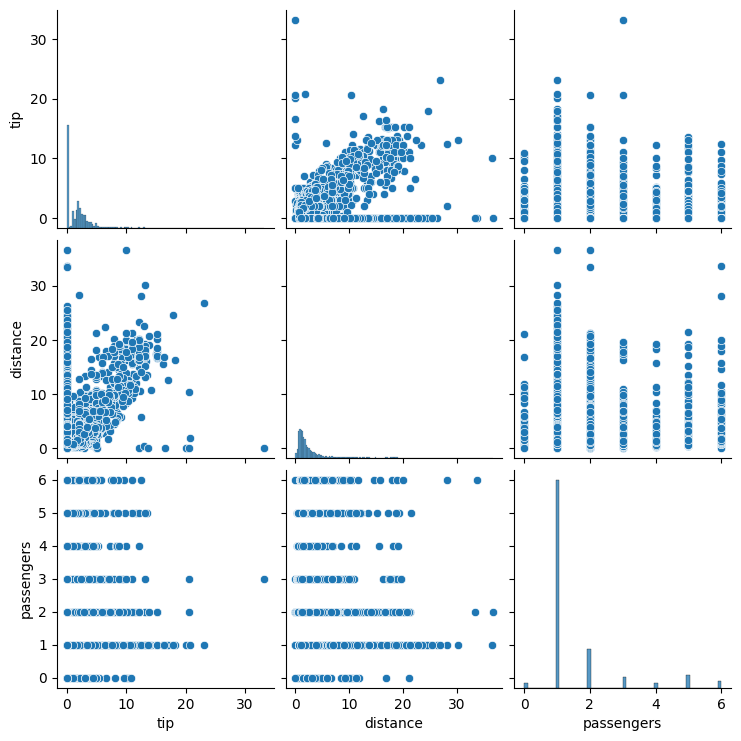

In [127]:
plot_features_num_regression(df, 'tip', ['distance', 'passengers'])

In [128]:
def get_features_cat_regression(data:pd.DataFrame, target_col:str,  pvalue:float=0.05) -> list:
    '''
    Devuelve una lista de columnas categóricas de un DataFrame cuya relación con la variable objetivo supera un nivel de significación estadística
    definido.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame de entrada que contiene las variables explicativas y la variable objetivo.
    target_col : str
        Columna del DataFrame que se utilizará como variable objetivo (numérica continua o discreta de alta cardinalidad).
    pvalue : float, optional
        Nivel de significación estadística para los tests de relación. Por defecto es 0.05.

    Returns
    -------
    list
        Lista de nombres de columnas categóricas cuya relación con la variable objetivo es significativa.
    '''

    data = data.dropna(axis=0)

    if not(isinstance(data, pd.DataFrame) and isinstance(target_col, str) and isinstance(pvalue, (int, float))):
        return print('Introduce el tipo de variable adecuado para cada parámetro.')
    
    columnas_categoricas = data.select_dtypes(exclude=['number']).columns

    if not target_col in data.select_dtypes(include=['number']).columns:
        return print('La columna objetivo debe existir y ser numérica.')

    salida = []
    for columna in columnas_categoricas:
        if data[columna].nunique() == 2:
            grupo_a, grupo_b = [data[data[columna] == valor][target_col] for valor in data[columna].unique()]
            _, p_valor = mannwhitneyu(grupo_a, grupo_b)
            if p_valor <= pvalue:
                salida.append(columna)
        else:
            lista = [data[data[columna] == valor][target_col] for valor in data[columna].unique()]
            _, p_valor = f_oneway(*lista)
            if p_valor <= pvalue:
                salida.append(columna)
            
    return salida


In [129]:
get_features_cat_regression(df, 'tip')

['color',
 'payment',
 'pickup_zone',
 'dropoff_zone',
 'pickup_borough',
 'dropoff_borough']

In [132]:
def plot_features_cat_regression(data:pd.DataFrame, target_col:str, columns:list=[], pvalue:float=0.05, with_individual_plot:bool=False) -> None:
    '''
    Genera histogramas de la variable objetivo agrupados por los valores de variables categóricas seleccionadas, considerando únicamente aquellas cuya
    relación con la variable objetivo es estadísticamente significativa.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame de entrada que contiene las variables a analizar.
    target_col : str, optional
        Columna del DataFrame que se utilizará como variable objetivo.
    columns : list of str, optional
        Lista de nombres de variables categóricas candidatas a representar. Si está vacía, se utilizan todas las variables categóricas.
    pvalue : float, optional
        Nivel de significación estadística para los tests de relación.
    with_individual_plot : bool, optional
        Indica si se deben generar gráficos individuales adicionales para cada variable seleccionada.

    Returns
    -------
    list
    Lista de nombres de columnas categóricas que han sido consideradas para los histogramas.
    '''

    columns = data.columns.to_list() if columns == [] else columns
    if not(isinstance(columns, list)):
        return print('Introduce el tipo de variable adecuado para cada parámetro.')

    columns_calc = get_features_cat_regression(data, target_col, pvalue)

    columnas_pintar = [col for col in columns if col in columns_calc]
    divisiones = math.ceil(len(columnas_pintar) / 4)
    for div in range(divisiones):
        ncols = min(4, len(columnas_pintar)-div*4)
        _, axs = plt.subplots(ncols=min(4, len(columnas_pintar)-div*4), figsize = (5*ncols, 5))
        for i, ax in enumerate(axs):
            sns.histplot(data[columnas_pintar[div*4+i]], ax=ax)
    
    return columnas_pintar


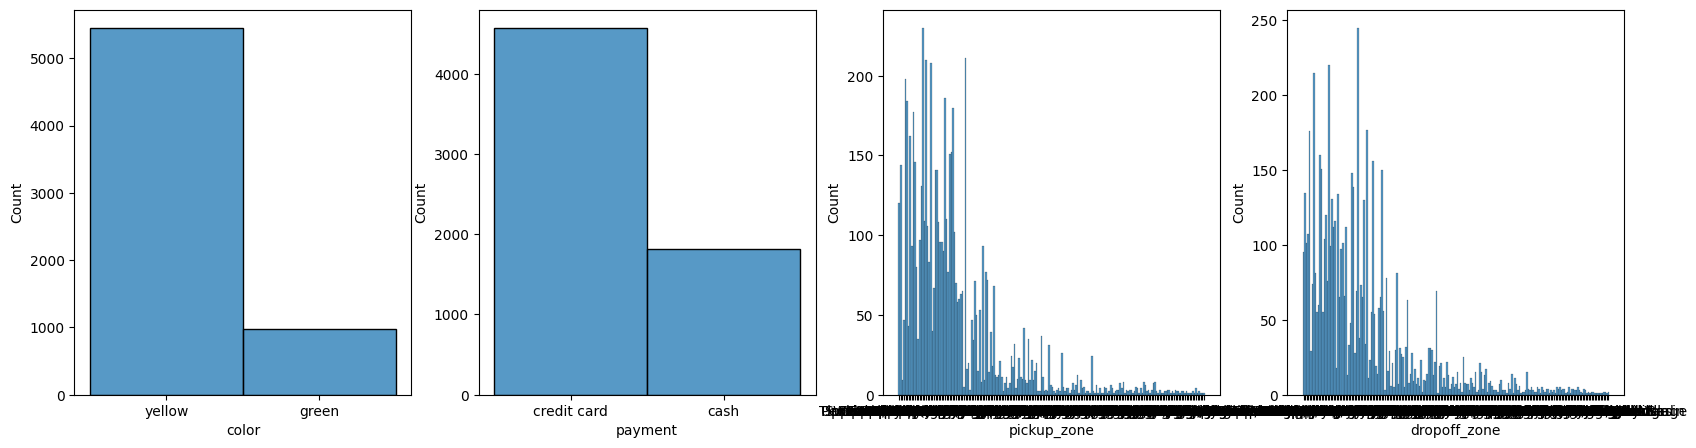

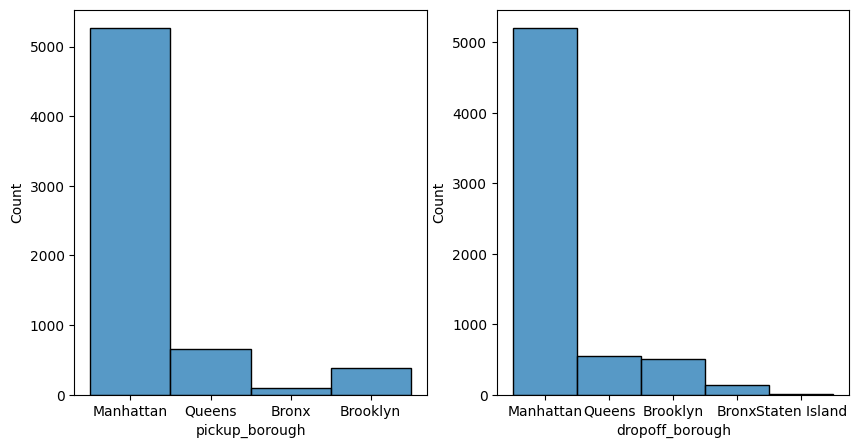

In [133]:
plot_features_cat_regression(df, 'tip');